## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\benja\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [29]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[128, 64, 128], ratio={}, regulizer=None, Drop=False, BN=False):
    """Code Here
    建立你的神經網路
    """
    drp_ratio = 0.25
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        ratio_in = []
        if regulizer.__name__ == 'l1':
            ratio_in.append(ratio['l1'])
        elif regulizer.__name__ == 'l2':
            ratio_in.append(ratio['l2'])
        else:
            ratio_in.append(ratio['l1'])
            ratio_in.append(ratio['l2'])
        print(regulizer.__name__)
        if i == 0:
            if regulizer.__name__ != 'None':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=regulizer(*ratio_in))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units,
                                       activation='relu',
                                       name='hidden_layer'+str(i+1),
                                      )(input_layer)
            if Drop: 
                x = Dropout(drp_ratio)(x)
            if BN:
                x = BatchNormalization()(x)
            
        else:
            if regulizer.__name__ != 'None':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=regulizer(*ratio_in))(x)
            else:
                x = keras.layers.Dense(units=n_units,
                                      activation='relu',
                                      name='hidden_layer'+str(i+1),
                                     )(x)
            if Drop:
                x = Dropout(drp_ratio)(x)
            if BN:
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [23]:
"""Code Here
設定超參數
"""
class null_regu():
    def __init__(self):
        self.__name__ = 'None'
N_regu = null_regu()
MOMENTUM = 0.95
ratio_mix = []
LEARNING_RATE = 0.01
BATCH_SIZE = 256
EPOCHS = 30
opts = [N_regu, l1, l2, l1_l2]
names = ['None', 'l1', 'l2', 'l1l2']
ratio = {'l1': 0.001, 'l2': 0.001}

In [30]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for name, regulizer in zip(names, opts):
    for Drop in [True, False]:
        for BN in [True, False]:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            print("Combination regulizer {}, Drop {}, BN {}".format(name, Drop, BN))
            model = build_mlp(input_shape=x_train.shape[1:], regulizer=regulizer, ratio=ratio, Drop=Drop, BN=BN)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            exp_name_tag = "re {} Drop {} BN {}".format(name, Drop, BN)
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

Combination regulizer None, Drop True, BN True
None
None
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normaliz

50000/50000 [==============================] - 6s 124us/step - loss: 1.7564 - acc: 0.3646 - val_loss: 1.6387 - val_acc: 0.4167
Epoch 6/30
50000/50000 [==============================] - 6s 124us/step - loss: 1.7343 - acc: 0.3697 - val_loss: 1.6115 - val_acc: 0.4303
Epoch 7/30
50000/50000 [==============================] - 6s 124us/step - loss: 1.7034 - acc: 0.3841 - val_loss: 1.6289 - val_acc: 0.4145
Epoch 8/30
50000/50000 [==============================] - 6s 127us/step - loss: 1.6934 - acc: 0.3869 - val_loss: 1.5807 - val_acc: 0.4378
Epoch 9/30
50000/50000 [==============================] - 6s 124us/step - loss: 1.6712 - acc: 0.3973 - val_loss: 1.5776 - val_acc: 0.4331
Epoch 10/30
50000/50000 [==============================] - 6s 124us/step - loss: 1.6646 - acc: 0.3996 - val_loss: 1.5715 - val_acc: 0.4424
Epoch 11/30
50000/50000 [==============================] - 6s 124us/step - loss: 1.6496 - acc: 0.4062 - val_loss: 1.5603 - val_acc: 0.4433
Epoch 12/30
50000/50000 [==================

50000/50000 [==============================] - 8s 157us/step - loss: 0.9598 - acc: 0.6584 - val_loss: 1.7293 - val_acc: 0.4547
Epoch 24/30
50000/50000 [==============================] - 8s 155us/step - loss: 0.9462 - acc: 0.6607 - val_loss: 1.6780 - val_acc: 0.4579
Epoch 25/30
50000/50000 [==============================] - 8s 160us/step - loss: 0.9272 - acc: 0.6675 - val_loss: 1.7658 - val_acc: 0.4513
Epoch 26/30
50000/50000 [==============================] - 8s 157us/step - loss: 0.9229 - acc: 0.6709 - val_loss: 1.6736 - val_acc: 0.4652
Epoch 27/30
50000/50000 [==============================] - 8s 159us/step - loss: 0.9072 - acc: 0.6765 - val_loss: 1.7152 - val_acc: 0.4591
Epoch 28/30
50000/50000 [==============================] - 8s 155us/step - loss: 0.8980 - acc: 0.6776 - val_loss: 1.6306 - val_acc: 0.4767
Epoch 29/30
50000/50000 [==============================] - 8s 165us/step - loss: 0.8811 - acc: 0.6854 - val_loss: 1.7102 - val_acc: 0.4524
Epoch 30/30
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 10s 192us/step - loss: 7.5118 - acc: 0.2424 - val_loss: 3.8652 - val_acc: 0.1635
Epoch 2/30
50000/50000 [==============================] - 8s 169us/step - loss: 3.2121 - acc: 0.2778 - val_loss: 3.4426 - val_acc: 0.1652
Epoch 3/30
50000/50000 [==============================] - 8s 168us/step - loss: 2.7547 - acc: 0.2890 - val_loss: 2.7311 - val_acc: 0.2199
Epoch 4/30
50000/50000 [==============================] - 9s 173us/step - loss: 2.5248 - acc: 0.2874 - val_loss: 2.5675 - val_acc: 0.2788
Epoch 5/30
50000/50000 [==============================] - 8s 167us/step - loss: 2.4323 - acc: 0.2928 - val_loss: 2.5809 - val_acc: 0.1708
Epoch 6/30
50000/50000 [==============================] - 8s 167us/step - loss: 2.3280 - acc: 0.2993 - val_loss: 2.2790 - val_acc: 0.3231
Epoch 7/30
50000/50000 [==============================] - 9s 172us/step - loss: 2.2446 - acc: 0.3082 - val_loss: 2.1672 -

Epoch 19/30
50000/50000 [==============================] - 8s 159us/step - loss: 2.1372 - acc: 0.2949 - val_loss: 2.1142 - val_acc: 0.2984
Epoch 20/30
50000/50000 [==============================] - 8s 170us/step - loss: 2.1257 - acc: 0.2959 - val_loss: 2.0390 - val_acc: 0.3268
Epoch 21/30
50000/50000 [==============================] - 8s 160us/step - loss: 2.1232 - acc: 0.2961 - val_loss: 2.1107 - val_acc: 0.3156
Epoch 22/30
50000/50000 [==============================] - 8s 164us/step - loss: 2.1174 - acc: 0.2984 - val_loss: 2.0550 - val_acc: 0.3204
Epoch 23/30
50000/50000 [==============================] - 8s 160us/step - loss: 2.1148 - acc: 0.2969 - val_loss: 2.0868 - val_acc: 0.3084
Epoch 24/30
50000/50000 [==============================] - 8s 162us/step - loss: 2.1234 - acc: 0.2948 - val_loss: 2.0302 - val_acc: 0.3466
Epoch 25/30
50000/50000 [==============================] - 8s 160us/step - loss: 2.1274 - acc: 0.2942 - val_loss: 2.0710 - val_acc: 0.3389
Epoch 26/30
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 8s 167us/step - loss: 7.1490 - acc: 0.2958 - val_loss: 3.5601 - val_acc: 0.2838
Epoch 2/30
50000/50000 [==============================] - 8s 154us/step - loss: 2.8915 - acc: 0.3186 - val_loss: 2.5755 - val_acc: 0.3307
Epoch 3/30
50000/50000 [==============================] - 8s 154us/step - loss: 2.3971 - acc: 0.3436 - val_loss: 2.1937 - val_acc: 0.3659
Epoch 4/30
50000/50000 [==============================] - 8s 152us/step - loss: 2.1397 - acc: 0.3557 - val_loss: 2.0672 - val_acc: 0.3582
Epoch 5/30
50000/50000 [==============================] - 8s 153us/step - loss: 2.0547 - acc: 0.3559 - val_loss: 2.1520 - val_acc: 0.3122
Epoch 6/30
50000/50000 [==============================] - 8s 152us/step - loss: 2.0124 - acc: 0.3591 - val_loss: 2.0645 - val_acc: 0.3250
Epoch 7/30
50000/50000 [==============================] - 8s 152us/step - loss: 1.9917 - acc: 0.3633 - val_loss: 2.0358 - 

50000/50000 [==============================] - 9s 172us/step - loss: 1.7624 - acc: 0.3974 - val_loss: 1.7257 - val_acc: 0.4118
Epoch 17/30
50000/50000 [==============================] - 9s 171us/step - loss: 1.7563 - acc: 0.4012 - val_loss: 1.6937 - val_acc: 0.4203
Epoch 18/30
50000/50000 [==============================] - 9s 175us/step - loss: 1.7664 - acc: 0.3929 - val_loss: 1.7253 - val_acc: 0.4039
Epoch 19/30
50000/50000 [==============================] - 9s 172us/step - loss: 1.7521 - acc: 0.3964 - val_loss: 1.7681 - val_acc: 0.3923
Epoch 20/30
50000/50000 [==============================] - 9s 174us/step - loss: 1.7524 - acc: 0.3961 - val_loss: 1.6969 - val_acc: 0.4194
Epoch 21/30
50000/50000 [==============================] - 9s 173us/step - loss: 1.7549 - acc: 0.3936 - val_loss: 1.7081 - val_acc: 0.4156
Epoch 22/30
50000/50000 [==============================] - 9s 172us/step - loss: 1.7617 - acc: 0.3909 - val_loss: 1.6748 - val_acc: 0.4339
Epoch 23/30
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 9s 184us/step - loss: 2.1556 - acc: 0.3809 - val_loss: 2.0550 - val_acc: 0.4023
Epoch 2/30
50000/50000 [==============================] - 8s 163us/step - loss: 1.8835 - acc: 0.4603 - val_loss: 1.9507 - val_acc: 0.4290
Epoch 3/30
50000/50000 [==============================] - 8s 165us/step - loss: 1.7583 - acc: 0.4908 - val_loss: 1.8474 - val_acc: 0.4531
Epoch 4/30
50000/50000 [==============================] - 8s 165us/step - loss: 1.6728 - acc: 0.5091 - val_loss: 1.9173 - val_acc: 0.4220
Epoch 5/30
50000/50000 [==============================] - 9s 172us/step - loss: 1.6070 - acc: 0.5185 - val_loss: 2.4263 - val_acc: 0.3227
Epoch 6/30
50000/50000 [==============================] - 9s 171us/step - loss: 1.5478 - acc: 0.5345 - val_loss: 1.7156 - val_acc: 0.4708
Epoch 7/30
50000/50000 [==============================] - 8s 165us/step - loss: 1.5022 - acc: 0.5431 - val_loss: 1.8457 - 

Epoch 22/30
50000/50000 [==============================] - 8s 157us/step - loss: 1.3735 - acc: 0.5684 - val_loss: 1.5935 - val_acc: 0.4786
Epoch 23/30
50000/50000 [==============================] - 8s 157us/step - loss: 1.3753 - acc: 0.5650 - val_loss: 1.5587 - val_acc: 0.5022
Epoch 24/30
50000/50000 [==============================] - 8s 157us/step - loss: 1.3659 - acc: 0.5717 - val_loss: 1.5623 - val_acc: 0.4912
Epoch 25/30
50000/50000 [==============================] - 8s 157us/step - loss: 1.3577 - acc: 0.5743 - val_loss: 1.5309 - val_acc: 0.5130
Epoch 26/30
50000/50000 [==============================] - 8s 158us/step - loss: 1.3493 - acc: 0.5778 - val_loss: 1.5832 - val_acc: 0.5031
Epoch 27/30
50000/50000 [==============================] - 8s 158us/step - loss: 1.3461 - acc: 0.5773 - val_loss: 1.5733 - val_acc: 0.5014
Epoch 28/30
50000/50000 [==============================] - 8s 158us/step - loss: 1.3446 - acc: 0.5782 - val_loss: 1.5716 - val_acc: 0.5030
Epoch 29/30
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 10s 194us/step - loss: 7.2801 - acc: 0.2232 - val_loss: 3.3690 - val_acc: 0.2385
Epoch 2/30
50000/50000 [==============================] - 9s 181us/step - loss: 2.8875 - acc: 0.2503 - val_loss: 2.5288 - val_acc: 0.2983
Epoch 3/30
50000/50000 [==============================] - 9s 180us/step - loss: 2.4193 - acc: 0.2658 - val_loss: 2.3422 - val_acc: 0.2443
Epoch 4/30
50000/50000 [==============================] - 9s 181us/step - loss: 2.2284 - acc: 0.2678 - val_loss: 2.2270 - val_acc: 0.2569
Epoch 5/30
50000/50000 [==============================] - 9s 182us/step - loss: 2.1789 - acc: 0.2740 - val_loss: 2.0710 - val_acc: 0.3227
Epoch 6/30
50000/50000 [==============================] - 9s 186us/step - loss: 2.1640 - acc: 0.2754 - val_loss: 2.1312 - val_acc: 0.2847
Epoch 7/30
50000/50000 [==============================] - 9s 182us/step - loss: 2.1587 - acc: 0.2775 - val_loss: 2.0683 -

50000/50000 [==============================] - 10s 193us/step - loss: 1.9164 - acc: 0.4635 - val_loss: 2.3427 - val_acc: 0.3538
Epoch 19/30
50000/50000 [==============================] - 10s 194us/step - loss: 1.9132 - acc: 0.4667 - val_loss: 2.2287 - val_acc: 0.3708
Epoch 20/30
50000/50000 [==============================] - 10s 195us/step - loss: 1.9112 - acc: 0.4624 - val_loss: 2.3905 - val_acc: 0.3408
Epoch 21/30
50000/50000 [==============================] - 10s 196us/step - loss: 1.9084 - acc: 0.4651 - val_loss: 2.3022 - val_acc: 0.3492
Epoch 22/30
50000/50000 [==============================] - 10s 197us/step - loss: 1.9009 - acc: 0.4651 - val_loss: 2.4160 - val_acc: 0.3238
Epoch 23/30
50000/50000 [==============================] - 10s 197us/step - loss: 1.8911 - acc: 0.4677 - val_loss: 2.1397 - val_acc: 0.3898
Epoch 24/30
50000/50000 [==============================] - 10s 195us/step - loss: 1.8838 - acc: 0.4677 - val_loss: 2.2189 - val_acc: 0.3561
Epoch 25/30
50000/50000 [=======

dict_keys(['re None Drop True BN True', 're None Drop True BN False', 're None Drop False BN True', 're None Drop False BN False', 're l1 Drop True BN True', 're l1 Drop True BN False', 're l1 Drop False BN True', 're l1 Drop False BN False', 're l2 Drop True BN True', 're l2 Drop True BN False', 're l2 Drop False BN True', 're l2 Drop False BN False', 're l1l2 Drop True BN True', 're l1l2 Drop True BN False', 're l1l2 Drop False BN True', 're l1l2 Drop False BN False'])


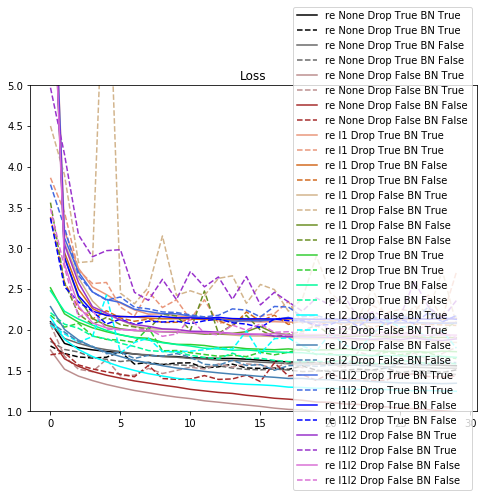

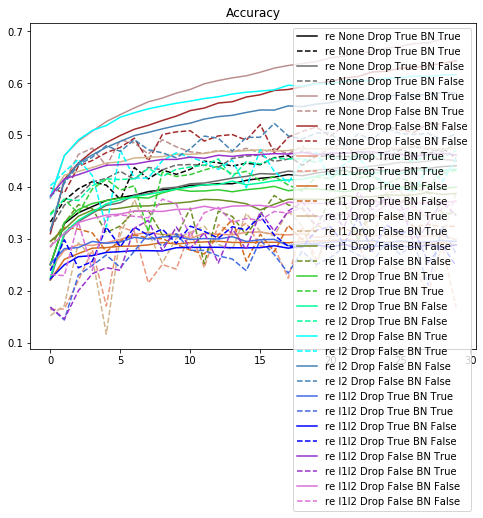

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ['k', 'dimgrey', 'rosybrown', 'brown',
             'darksalmon', 'chocolate', 'tan', 'olivedrab',
             'limegreen', 'mediumspringgreen', 'aqua', 'steelblue',
             'royalblue', 'b', 'darkorchid', 'orchid']
print(results.keys())

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([1, 5])
plt.legend(loc='right')
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
整體看起來regulizer用l2或不用配上Batch normalization比較好, Dropout則是在沒有Batch normalization的時候開會比較好